# Laboratorio 3 - MLFLow & Feast

Diego Andrés Alonzo Medinilla - 20172

## Configuración del entorno

### Instalación de dependencias

In [ ]:
%pip install mlflow feast scikit-learn pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Verificación de la instalación

In [1]:
import mlflow
import feast

print(mlflow.__version__)
print(feast.__version__)

3.5.0
0.47.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlflow import MlflowClient
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor

## Carga y exploración del dataset

### Carga del dataset

In [3]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
# TODO: Cargar el dataset
housing = fetch_california_housing()
# TODO: Convertir a DataFrame con nombres de columnas apropiados
df = pd.DataFrame(housing['data'])
df = df.rename(
    {
        0:'MedInc',
        1:'HouseAge',
        2:'AveRooms',
        3:'AveBedrms',
        4:'Population',
        5:'AveOccup',
        6:'Latitude',
        7:'Longitude',
        # 8:'MedHouseVal' # There is no MedHouseVal in the doc
    }, 
    axis=1)
df['MedHouseVal'] = housing['target']

In [4]:
# TODO: Mostrar las primeras 5 filas
df.head(5)

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422

In [5]:
# TODO: Mostrar información básica del dataset (shape, tipos de datos)
print(df.shape)
print(df.info())
df.describe()

(20640, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None


MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.540000   -124.350000      0.149990  
25%        2.429741     33.930000   -121.800000      1.196000  
50%        2.818116     34.260000   -118.490000      1.797000  
75%        3.282261     37.710000   -118.010000      2.647250  
max     1243.333333     41.950000   -114.310000      5.000010

### Análisis Exploratorio

In [6]:
df.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.540000   -124.350000      0.149990  
25%        2.429741     33.930000   -121.800000      1.196000  
50%        2.818116     34.260000   -118.490000      1.797000  
75%        3.282261     37.710000   -118.010000      2.647250  
max     1243.333333     41.950000   -114.310000      5.000010

In [7]:
for col in df.columns:
    print(f"{col} has # {df[df[col].isna()].shape[0]} nulls")

MedInc has # 0 nulls
HouseAge has # 0 nulls
AveRooms has # 0 nulls
AveBedrms has # 0 nulls
Population has # 0 nulls
AveOccup has # 0 nulls
Latitude has # 0 nulls
Longitude has # 0 nulls
MedHouseVal has # 0 nulls


array([[<Axes: title={'center': 'MedHouseVal'}>]], dtype=object)

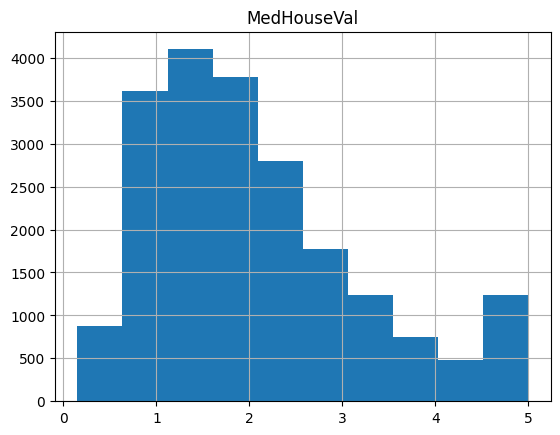

In [8]:
df.hist('MedHouseVal')

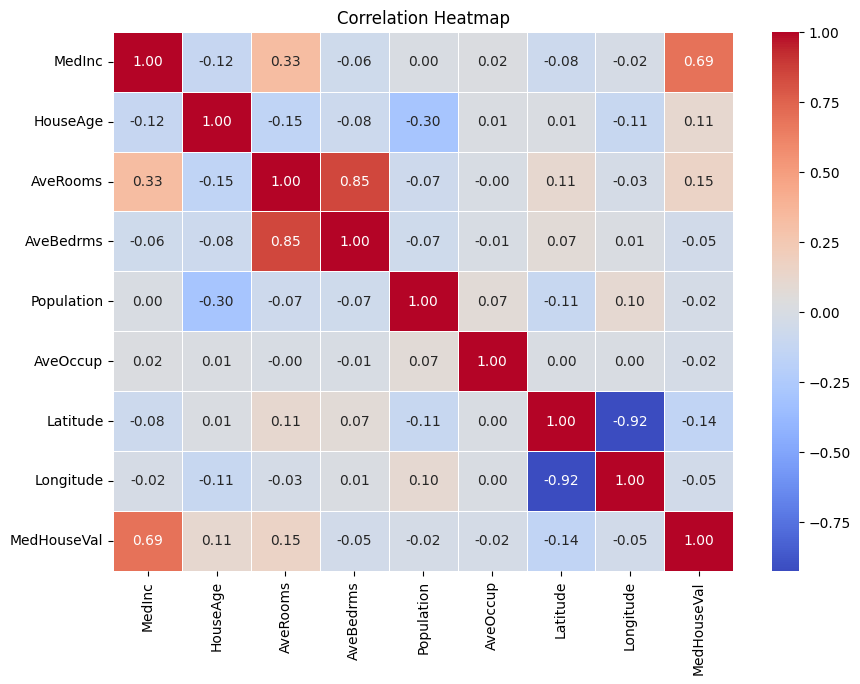

In [9]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## Preparación de los Datos

### División de datos

In [10]:
from sklearn.model_selection import train_test_split

# TODO: Separar features (X) y target (y)
# TODO: Dividir en train y test con random_state=42
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(df[df.columns[:-1]]), 
    np.array(df[df.columns[-1]]),
    test_size=0.2, 
    random_state=42
)

### Feature Engineering

In [11]:
# TODO: Crear features derivadas

## Ingreso medio por persona por la vivienda MedInc/AveOccup
df['MedPP'] = df['MedInc']/df['AveOccup']
## Razon de dormitorios por habitación AveBedrms/AveRooms
df['RatioRoomsBed'] = df['AveBedrms']/df['AveRooms']
## Población total en el distrito = Pt M = Pt/Viviendas => M*Pt = Viviendas por distrito
df['HouseP'] = df['AveOccup'] * df['Population']

df = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedPP', 'RatioRoomsBed',
       'HouseP', 'MedHouseVal']]
# TODO: Actualizar los conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(df[df.columns[:-1]]), 
    np.array(df[df.columns[-1]]),
    test_size=0.2, 
    random_state=42
)

## Experimentación con MLFlow

### Configuración de MLFlow

In [18]:
import mlflow
import mlflow.sklearn
# TODO: Configurar tracking URI (puede ser local)
mlflow.set_tracking_uri("file:///home/diggspapu/lab-3-mlops/mlruns")
# TODO: Crear un experimento llamado "california-housing-prediction"
mlflow.set_experiment("california-housing-prediction")

2025/10/19 19:36:40 INFO mlflow.tracking.fluent: Experiment with name 'california-housing-prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/diggspapu/lab-3-mlops/mlruns/475289976526174453', creation_time=1760927800425, experiment_id='475289976526174453', last_update_time=1760927800425, lifecycle_stage='active', name='california-housing-prediction', tags={}>

### Entrenamiento de modelos

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# TODO: Implementar función para entrenar y loggear modelo en MLflow
def train_model(model, X_train, Y_train, X_test, Y_test, model_name, params):
    with mlflow.start_run(run_name=model_name) as run:
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)

        # Métricas
        rmse = np.sqrt(mean_squared_error(Y_test, predictions))
        mae = mean_absolute_error(Y_test, predictions)
        r2 = r2_score(Y_test, predictions)

        # Log en MLflow
        mlflow.log_params(params)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)

        # Log del modelo
        mlflow.sklearn.log_model(model, artifact_path="model")

        # Registrar el modelo en el Model Registry
        mlflow.register_model(f"runs:/{run.info.run_id}/model", model_name)
# TODO: Entrenar los 3 modelos y registrar métricas
# Parámetros y entrenamiento de Linear Regression
linear_regression_params = {
    'positive': False,
}

train_model(
    LinearRegression(**linear_regression_params),
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    model_name='linear_regression',
    params=linear_regression_params
)

# Parámetros y entrenamiento de Random Forest
random_forest_regression_params = {
    'criterion': 'squared_error',
    'max_depth': 100,
    'min_samples_split': 0.5,
    'min_weight_fraction_leaf': 0.1,
    'max_features': 'log2',
    'max_leaf_nodes': 30,
    'min_impurity_decrease': 0.4  # corregido
}

train_model(
    RandomForestRegressor(**random_forest_regression_params),
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    model_name='random_forest_regression',
    params=random_forest_regression_params
)

gradient_boosting_regressor_params = {
    'loss':'absolute_error',
    'learning_rate':0.02,
    'n_estimators':1000,
    'subsample':0.6,
    'criterion':'squared_error'
}

train_model(
    GradientBoostingRegressor(**gradient_boosting_regressor_params),
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    model_name='gradient_boosting_regressor',
    params=gradient_boosting_regressor_params
)


2025/10/19 19:36:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 19:36:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'linear_regression'.
2025/10/19 19:36:54 WARNING mlflow.tracking._model_registry.fluent: Run with id 472a02acf0aa4e4bab3a692473fc34fd has no artifacts at artifact path 'model', registering model based on models:/m-454d00772b734ca9b7b205dc0a17c17e instead
Created version '1' of model 'linear_regression'.
2025/10/19 19:36:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 19:36:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'random_forest_regression'.
2

## Feature Store con Feast

### Configuración de Feast

feast init california_feature_store

cd california_feature_store

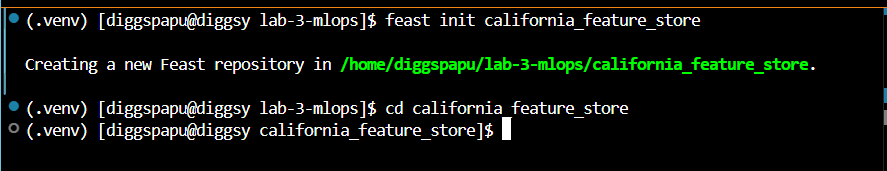

### Definición de Features

In [20]:
# from feast import Entity, FeatureView, Field, FileSource
# from feast.types import Float64, Int64
# from datetime import timedelta
# # TODO: Definir la entidad (house)
# house = Entity(
#     name='house',
#     join_keys=['house_id']
# )
# # TODO: Definir el source (archivo parquet con los datos)
# house_data_source = FileSource(
#     path="/home/diggspapu/lab-3-mlops/california_feature_store/feature_repo/data/house_features.parquet",  # ruta al archivo parquet
#     timestamp_field="event_timestamp",   # campo de timestamp
#     created_timestamp_column="created",  # opcional: cuándo se creó el registro
# )
# # TODO: Crear FeatureView con las features principales
# house_feature_view = FeatureView(
#     name="house_features",
#     entities=[house],
#     ttl=timedelta(days=1),  # tiempo de vida de los datos en el feature store
#     schema=[
#         Field(name="MedInc", dtype=Int64),
#         Field(name="HouseAge", dtype=Float64),
#         Field(name="AveRooms", dtype=Float64),
#         Field(name="AveBedrms", dtype=Float64),
#         Field(name="Population", dtype=Float64),
#         Field(name="AveOccup", dtype=Float64),
#         Field(name="Latitude", dtype=Float64),
#         Field(name="Longitude", dtype=Float64),
#         Field(name="MedPP", dtype=Float64),
#         Field(name="RatioRoomsBed", dtype=Float64),
#         # Field(name="MedHouseVal", dtype=Float64), # Este no es un feature, es target val.
#     ],
#     source=house_data_source,
#     online=True,  # permite servir en tiempo real
# )

### Materialización de Features

In [28]:
# TODO: Guardar datos en formato parquet con timestamp
df['event_timestamp'] = pd.Timestamp.now()
df['created'] = pd.Timestamp.now()
df['house_id'] = df.index.astype(int)
df.to_parquet('/home/diggspapu/lab-3-mlops/california_feature_store/feature_repo/data/house_features.parquet',
              compression='snappy') 
# TODO: Ejecutar feast apply
# TODO: Ejecutar feast materialize 2025-10-01T00:00:00 2025-10-19T23:59:59

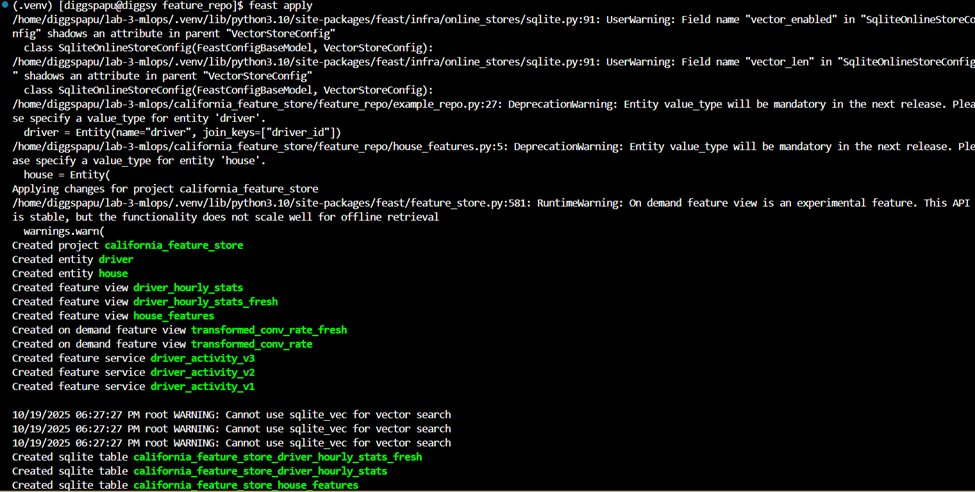
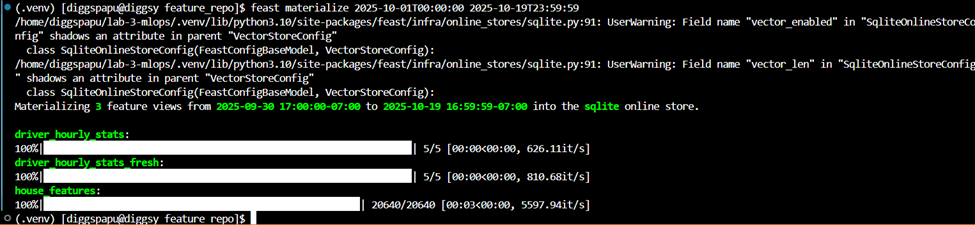

### Consumo de Features

In [32]:
from feast import FeatureStore

# Inicializar el FeatureStore desde el repositorio
store = FeatureStore(repo_path="/home/diggspapu/lab-3-mlops/california_feature_store/feature_repo")
# Lista de entidades para las que quieres recuperar features
entity_df = pd.read_parquet("/home/diggspapu/lab-3-mlops/california_feature_store/feature_repo/data/house_features.parquet")

In [33]:
features = store.get_online_features(
    features=[
        "house_features:MedInc",
        "house_features:HouseAge",
        "house_features:AveRooms",
        "house_features:AveBedrms",
        "house_features:Population",
        "house_features:AveOccup",
        "house_features:Latitude",
        "house_features:Longitude",
        "house_features:MedPP",
        "house_features:RatioRoomsBed",
        "house_features:HouseP",
    ],
    entity_rows=entity_df.to_dict(orient="records")
).to_df()

features.head()

house_id  AveRooms  HouseAge     MedPP       HouseP  AveOccup  AveBedrms  \
0         0  6.984127      41.0  3.257687   822.888889  2.555556   1.023810   
1         1  6.238137      21.0  3.934608  5065.730228  2.109842   0.971880   
2         2  8.288136      52.0  2.589838  1389.920904  2.802260   1.073446   
3         3  5.817352      52.0  2.214765  1421.753425  2.547945   1.073059   
4         4  6.281853      52.0  1.763125  1232.528958  2.181467   1.081081   

   MedInc  Longitude  Latitude  RatioRoomsBed  Population  
0       8    -122.23     37.88       0.146591       322.0  
1       8    -122.22     37.86       0.155797      2401.0  
2       7    -122.24     37.85       0.129516       496.0  
3       5    -122.25     37.85       0.184458       558.0  
4       3    -122.25     37.85       0.172096       565.0

In [36]:
for model in ['linear_regression', 'random_forest_regression','gradient_boosting_regressor']:
    print(f"____{model}____")
    # Cargar modelo desde MLflow
    model_uri = f"models:/{model}/None" # Ajusta el nombre si es diferente
    model = mlflow.sklearn.load_model(model_uri)

    # Seleccionar columnas de entrada
    X = features[[
        "MedInc", "HouseAge", "AveRooms", "AveBedrms",
        "Population", "AveOccup", "Latitude", "Longitude",
        "MedPP", "RatioRoomsBed", "HouseP"
    ]]

    # Hacer predicciones
    predictions = model.predict(X)

    # Mostrar resultados
    for house_id, pred in zip(features["house_id"], predictions):
        print(f"Predicción para house_id {house_id}: {pred}")

____linear_regression____
Predicción para house_id 0: 4.261807704929353
Predicción para house_id 1: 4.736701228770947
Predicción para house_id 2: 3.785234637398119
Predicción para house_id 3: 3.2075470718407146
Predicción para house_id 4: 2.655767865840474
Predicción para house_id 5: 2.8644450900146055
Predicción para house_id 6: 2.611333644404887
Predicción para house_id 7: 2.6780876184608644
Predicción para house_id 8: 1.9210801922405878
Predicción para house_id 9: 2.6229453520538186
Predicción para house_id 10: 2.3520322465213894
Predicción para house_id 11: 2.545353472582491
Predicción para house_id 12: 2.2491855626597825
Predicción para house_id 13: 2.306142139454792
Predicción para house_id 14: 1.8556074487532968
Predicción para house_id 15: 1.7604829881996409
Predicción para house_id 16: 2.0381304702968066
Predicción para house_id 17: 1.91975204371316
Predicción para house_id 18: 1.677522875747826
Predicción para house_id 19: 1.937109395211202
Predicción para house_id 20: 1.3396

/home/diggspapu/lab-3-mlops/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(



Predicción para house_id 12284: 0.5792995192020101
Predicción para house_id 12285: 1.5008915569304477
Predicción para house_id 12286: 0.4921006380141151
Predicción para house_id 12287: 1.2259267951693928
Predicción para house_id 12288: 1.4528138340045018
Predicción para house_id 12289: 0.8759281897978042
Predicción para house_id 12290: 1.286740007950165
Predicción para house_id 12291: 0.7630193431347934
Predicción para house_id 12292: 0.8908935270221789
Predicción para house_id 12293: 1.453882455516883
Predicción para house_id 12294: 0.9787663947927214
Predicción para house_id 12295: 0.9378820152954646
Predicción para house_id 12296: 0.7542505429252984
Predicción para house_id 12297: 1.0361295780518418
Predicción para house_id 12298: 2.1945425386534225
Predicción para house_id 12299: 0.931980692909562
Predicción para house_id 12300: 0.6503837178767782
Predicción para house_id 12301: 0.7968539740382568
Predicción para house_id 12302: 0.82029973041017
Predicción para house_id 12303: 1.8

/home/diggspapu/lab-3-mlops/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(



Predicción para house_id 5727: 1.991695565828472
Predicción para house_id 5728: 2.541042981315459
Predicción para house_id 5729: 1.9274729955723242
Predicción para house_id 5730: 2.541042981315459
Predicción para house_id 5731: 2.3419041698631955
Predicción para house_id 5732: 2.541042981315459
Predicción para house_id 5733: 2.541042981315459
Predicción para house_id 5734: 2.3419041698631955
Predicción para house_id 5735: 1.9274729955723242
Predicción para house_id 5736: 2.3419041698631955
Predicción para house_id 5737: 1.9274729955723242
Predicción para house_id 5738: 2.541042981315459
Predicción para house_id 5739: 2.541042981315459
Predicción para house_id 5740: 2.2866100366905853
Predicción para house_id 5741: 2.3419041698631955
Predicción para house_id 5742: 1.9274729955723242
Predicción para house_id 5743: 2.3419041698631955
Predicción para house_id 5744: 1.9274729955723242
Predicción para house_id 5745: 1.9274729955723242
Predicción para house_id 5746: 1.991695565828472
Predicc

/home/diggspapu/lab-3-mlops/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Predicción para house_id 0: 4.289405935197981
Predicción para house_id 1: 4.134031644513305
Predicción para house_id 2: 3.919247768240493
Predicción para house_id 3: 3.0109320109152478
Predicción para house_id 4: 2.4847387267989123
Predicción para house_id 5: 2.6820869132408833
Predicción para house_id 6: 2.2983089161965227
Predicción para house_id 7: 2.510840972627494
Predicción para house_id 8: 1.6004719965350205
Predicción para house_id 9: 2.393204060371609
Predicción para house_id 10: 2.0362214785977866
Predicción para house_id 11: 2.3690878399690214
Predicción para house_id 12: 1.866649427421801
Predicción para house_id 13: 1.992753557520119
Predicción para house_id 14: 1.5098096718945169
Predicción para house_id 15: 1.2244279579524968
Predicción para house_id 16: 1.630568711379286
Predicción para house_id 17: 1.4794850116659843
Predicción para house_id 18: 1.2156814215388172
Predicción para house_id 19: 1.4275236292991762
Predicción para house_id 20: 0.9826460284515319
Predicción